In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = "/content/drive/MyDrive/Covid19 Dataset/Train"
validation_dir = "/content/drive/MyDrive/Covid19 Dataset/Val"
test_dir= "/content/drive/MyDrive/Covid19 Dataset/Test"


In [5]:
img_size = (256, 256)
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


In [7]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1065 images belonging to 2 classes.
Found 356 images belonging to 2 classes.


In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Corona Virus Disease
1 : Normal


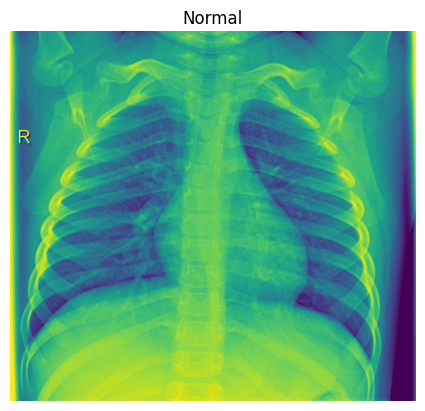

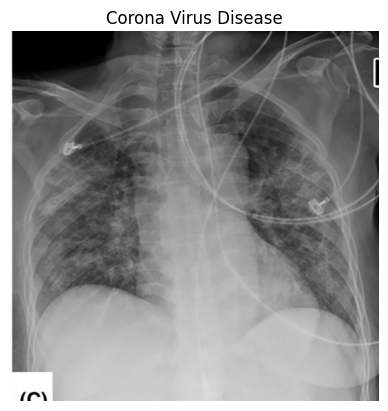

In [9]:
import os
import random
import matplotlib.pyplot as plt
def plot_sample_images(directory, label):
    class_labels = ['Normal', 'Corona Virus Disease']
    class_dir = os.path.join(directory, class_labels[label])
    image_files = os.listdir(class_dir)
    random_image = random.choice(image_files)
    img_path = os.path.join(class_dir, random_image)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(class_labels[label])
    plt.axis('off')
    plt.show()

plot_sample_images(test_dir, 0) # Normal
plot_sample_images(test_dir, 1) # COVID

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [12]:

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)


Epoch 1/10
33/33 [==============================] - 587s 18s/step - loss: 4.0320 - accuracy: 0.5644 - val_loss: 0.5437 - val_accuracy: 0.7585
Epoch 2/10
33/33 [==============================] - 47s 1s/step - loss: 0.5236 - accuracy: 0.7764 - val_loss: 0.5460 - val_accuracy: 0.7557
Epoch 3/10
33/33 [==============================] - 48s 1s/step - loss: 0.4560 - accuracy: 0.8141 - val_loss: 0.3717 - val_accuracy: 0.8381
Epoch 4/10
33/33 [==============================] - 47s 1s/step - loss: 0.5253 - accuracy: 0.7415 - val_loss: 0.2849 - val_accuracy: 0.9148
Epoch 5/10
33/33 [==============================] - 47s 1s/step - loss: 0.3857 - accuracy: 0.8229 - val_loss: 0.2585 - val_accuracy: 0.9290
Epoch 6/10
33/33 [==============================] - 55s 2s/step - loss: 0.3653 - accuracy: 0.8170 - val_loss: 0.2328 - val_accuracy: 0.9261
Epoch 7/10
33/33 [==============================] - 57s 2s/step - loss: 0.3217 - accuracy: 0.8364 - val_loss: 0.2181 - val_accuracy: 0.9091
Epoch 8/10
33/33 [

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
data_path_test=test_dir
test_generator = test_datagen.flow_from_directory(
    data_path_test,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

# Evaluate the model on the test set
results = model.evaluate(test_generator)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

Found 260 images belonging to 2 classes.
9/9 [==============================] - 7s 786ms/step - loss: 0.1483 - accuracy: 0.9615
Test Loss: 0.1482803076505661
Test Accuracy: 0.9615384340286255


In [21]:
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

9/9 [==============================] - 7s 813ms/step
Confusion Matrix:
[[128   2]
 [  8 122]]


9/9 [==============================] - 7s 804ms/step


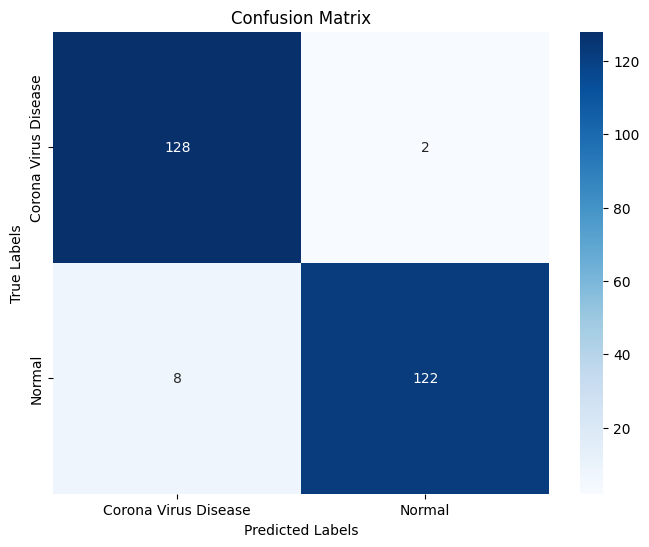

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Predict the labels using the model
predictions = model.predict(test_generator)

predictions=(predictions>0.5).astype(int)
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels,predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()